In [35]:
#-------------------------Imports---------------------------
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib

from scipy.stats import multivariate_normal
from scipy.stats import kstest

import h5py
import os
from astropy.cosmology import Planck15
from astropy.cosmology import FlatLambdaCDM

###########################
# CONSTANTS
###########################
H0GLOB= 69#67.9 #69
Om0GLOB=0.3
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s

xmax=100
ymax=100
zmax=100
half_box_size=2

Npoints=1000
Sigma=10

cosmoglob = Planck15
cosmofast = FlatLambdaCDM(H0=H0GLOB, Om0=Om0GLOB)
H0=cosmoglob.H(0).value

In [2]:
#--------------------------definitions-------------------------
def NumOfDS(x,y,z):
    r=np.sqrt(x**2+y**2+z**2)
    numberofDS=1000/r
    #numberofDS=10
    num=int(numberofDS)
    #print(num)
    if num>0:
        return num
    else:
        return 1

In [3]:
#----------------------Create the box & fill it with hosts-------------------
x=np.random.normal(loc=0,scale=Sigma,size=Npoints)
y=np.random.normal(loc=0,scale=Sigma,size=Npoints)
z=np.random.normal(loc=0,scale=Sigma,size=Npoints)

In [4]:
'''fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()

ax.scatter(x, y, z, c = 'b', s = 5)
ax.set_title('Host-Dristibution')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)
#plt.savefig('HostDist.pdf')'''

"fig = plt.figure(figsize = (10,10))\nax = plt.axes(projection='3d')\nax.grid()\n\nax.scatter(x, y, z, c = 'b', s = 5)\nax.set_title('Host-Dristibution')\n\n# Set axes label\nax.set_xlabel('x', labelpad=20)\nax.set_ylabel('y', labelpad=20)\nax.set_zlabel('z', labelpad=20)\n#plt.savefig('HostDist.pdf')"

In [5]:
#-------This will be movend into a function
x_Dark=[]
y_Dark=[]
z_Dark=[]
arr_n=[]
perc=0.4
NDS=int(0.4*Npoints)
indices=np.zeros(NDS)
for k in range(NDS):
    i=np.random.randint(0, Npoints-1)
    indices[k]=i
    dist_x=x[i]
    dist_y=y[i]
    dist_z=z[i]
    n=NumOfDS(dist_x,dist_y,dist_z)
    arr_n=np.append(arr_n,n)
    x_DS=np.random.uniform(-half_box_size,half_box_size,n)
    y_DS=np.random.uniform(-half_box_size,half_box_size,n)
    z_DS=np.random.uniform(-half_box_size,half_box_size,n)
    
    #x_DS=np.random.uniform(0,1,n)
    #y_DS=np.random.uniform(0,1,n)
    #z_DS=np.random.uniform(0,1,n)
    
    x_Dark=np.append(x_Dark,dist_x+x_DS)
    y_Dark=np.append(y_Dark,dist_y+y_DS)
    z_Dark=np.append(z_Dark,dist_z+z_DS)
#--------only unique indices of host-DS
filtered=np.unique(indices)


In [6]:
'''fig2 = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()

ax.scatter(x_Dark, y_Dark, z_Dark, c = 'g', s = 10)
ax.set_title('DS-Dristibution')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)
#plt.savefig('DSDist.pdf')'''

"fig2 = plt.figure(figsize = (10,10))\nax = plt.axes(projection='3d')\nax.grid()\n\nax.scatter(x_Dark, y_Dark, z_Dark, c = 'g', s = 10)\nax.set_title('DS-Dristibution')\n\n# Set axes label\nax.set_xlabel('x', labelpad=20)\nax.set_ylabel('y', labelpad=20)\nax.set_zlabel('z', labelpad=20)\n#plt.savefig('DSDist.pdf')"

In [7]:
'''figtot = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()
ax1 = figtot.add_subplot(111,projection='3d')

ax1.scatter(x, y, z, c = 'b', marker="*", label='Host')
ax1.scatter(x_Dark, y_Dark, z_Dark, s=5, c = 'g', marker="o", label='DS')
plt.legend(loc='upper left');
#plt.savefig('DS_and_Host.pdf')'''

'figtot = plt.figure(figsize = (10,10))\nax = plt.axes(projection=\'3d\')\nax.grid()\nax1 = figtot.add_subplot(111,projection=\'3d\')\n\nax1.scatter(x, y, z, c = \'b\', marker="*", label=\'Host\')\nax1.scatter(x_Dark, y_Dark, z_Dark, s=5, c = \'g\', marker="o", label=\'DS\')\nplt.legend(loc=\'upper left\');\n#plt.savefig(\'DS_and_Host.pdf\')'

In [8]:
'''figtot2dxy = plt.figure(figsize = (10,10))
ax = plt.axes()
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(linestyle='dotted', linewidth='0.6')
ax.scatter(x, y, c = 'b', marker="*", label='Host')
ax.scatter(x_Dark, y_Dark, s=5, c = 'g', marker="o", label='DS')
plt.legend(loc='upper left');
#plt.savefig('DS_and_Host_xy.pdf')'''

'figtot2dxy = plt.figure(figsize = (10,10))\nax = plt.axes()\nax.grid()\nax.tick_params(axis=\'both\', which=\'major\', labelsize=14)\nax.grid(linestyle=\'dotted\', linewidth=\'0.6\')\nax.scatter(x, y, c = \'b\', marker="*", label=\'Host\')\nax.scatter(x_Dark, y_Dark, s=5, c = \'g\', marker="o", label=\'DS\')\nplt.legend(loc=\'upper left\');\n#plt.savefig(\'DS_and_Host_xy.pdf\')'

In [9]:
#--------------test-----------------
all_px=[]
all_py=[]
all_pz=[]
#this works is there is at least 1 DS for an Host
for h in range(len(indices)):
    if h==0:
        pos=0
    n=int(arr_n[h])
    if n==1:
        xdata=x_Dark[pos]-x[int(indices[h])]
        ydata=y_Dark[pos]-y[int(indices[h])]
        zdata=z_Dark[pos]-z[int(indices[h])]
    else:
        xdata=x_Dark[pos:pos+n]-x[int(indices[h])]
        ydata=y_Dark[pos:pos+n]-y[int(indices[h])] 
        zdata=z_Dark[pos:pos+n]-z[int(indices[h])] 
        
    pos=(pos+n)

    statx,pvaluex=kstest(xdata,'uniform',args=(-half_box_size,half_box_size))
    staty,pvaluey=kstest(ydata,'uniform',args=(-half_box_size,half_box_size))
    statz,pvaluez=kstest(zdata,'uniform',args=(-half_box_size,half_box_size))
    all_px=np.append(all_px,statx)
    all_py=np.append(all_py,staty)
    all_pz=np.append(all_pz,statz)

print(np.mean(all_px))
print(np.mean(all_py))
print(np.mean(all_pz))

0.506186554931149
0.5108958991953679
0.5060167502977719


(array([1.57554733e-01, 1.71281092e-01, 1.66655906e-01, 1.57853132e-01,
        1.68893900e-01, 1.76801476e-01, 1.75757079e-01, 1.79487068e-01,
        1.79039469e-01, 1.71579492e-01, 1.85753450e-01, 1.76950676e-01,
        1.88140643e-01, 1.86350248e-01, 1.93959425e-01, 1.89334239e-01,
        1.93511827e-01, 1.82769458e-01, 1.94108625e-01, 1.82321860e-01,
        2.02016201e-01, 1.91273833e-01, 2.00524206e-01, 1.90378636e-01,
        1.89931037e-01, 1.97540215e-01, 1.89334239e-01, 2.00375006e-01,
        1.93959425e-01, 1.97689414e-01, 2.10968175e-01, 2.09476179e-01,
        2.15145762e-01, 2.00225807e-01, 2.07088986e-01, 2.10371377e-01,
        2.15742561e-01, 2.01419403e-01, 1.97987813e-01, 2.21412144e-01,
        2.12609370e-01, 2.05746190e-01, 2.04254195e-01, 2.00822605e-01,
        2.12758570e-01, 2.08431782e-01, 2.12012572e-01, 2.20666146e-01,
        2.11117374e-01, 2.12310971e-01, 2.12161771e-01, 2.12609370e-01,
        2.22307341e-01, 2.18875751e-01, 2.22754940e-01, 2.124601

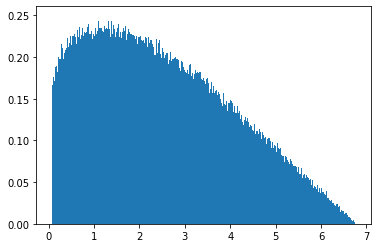

In [46]:
#------------------MC-rejection-sampling---------------------------------
#this will be a function
N=100
h=H0/100
r0=5*h
gamma=1.8
rmin=0.1*h
rmax=10*h

#target function
target_dist= lambda r: N*(r/r0)**(-gamma)
#envelope
envelop_dist=lambda r: N*(r/r0)**(-2)

def rejection():
    while True:
        #x=np.random.uniform(rmin, rmax)
        x=np.random.triangular(rmin,rmin,rmax)
        wall=envelop_dist(x)
        p=np.random.uniform(0, wall)
        if p<target_dist(x):
            return x
samples = [rejection() for x in range(1000000)]
matplotlib.pyplot.hist(samples,bins=1000,density=True)
